In [ ]:
!pip install apimoex

In [ ]:
import sys
import apimoex
import pandas as pd
import requests
import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.model_selection import train_test_split
from scipy.stats import shapiro, kstest
from statsmodels.tsa.stattools import adfuller

In [ ]:
def get_trading_days(start_date: datetime.datetime, weeks: int) -> list:
    trading_days = []
    current_date = start_date

    for _ in range(weeks * 5):  # 5 working hour
        while current_date.weekday() >= 5:
            current_date -= datetime.timedelta(days=1)

        trading_days.append(current_date.date())
        current_date -= datetime.timedelta(days=1)

    return trading_days

def fetch_historical_data(ticker: str, days: int = 365) -> pd.DataFrame:
    session = requests.Session()
    all_data = []

    market_open = datetime.time(9, 59)
    market_close = datetime.time(18, 39)

    trading_days = get_trading_days(datetime.datetime.now(), weeks=days//7)

    for day in trading_days:
        start_datetime = datetime.datetime.combine(day, market_open)
        end_datetime = datetime.datetime.combine(day, market_close)

        try:
            data = apimoex.get_market_candles(
                session=session,
                security=ticker,
                interval=1,
                start=start_datetime.strftime('%Y-%m-%d %H:%M'),
                end=end_datetime.strftime('%Y-%m-%d %H:%M')
            )

            if data:
                df_day = pd.DataFrame(data)
                df_day['datetime'] = pd.to_datetime(df_day['begin'], format='%Y-%m-%d %H:%M:%S')
                df_day.set_index('datetime', inplace=True)
                all_data.append(df_day)

        except Exception as e:
            print(f"Error to get {day}: {str(e)}")

    full_df = pd.concat(all_data).sort_index()
    return full_df[['open', 'high', 'low', 'close', 'volume']]

try:
    lkoh_data = fetch_historical_data("LKOH", days=365)
    print(lkoh_data.head())
    print(f"\nLen: {len(lkoh_data)}")

    print("\nFirst timestep:", lkoh_data.index.min())
    print("Last timestep:", lkoh_data.index.max())

except Exception as e:
    print(f"Error: {str(e)}")

                       open    high     low   close  volume
datetime                                                   
2024-04-01 09:59:00  7574.0  7574.0  7574.0  7574.0    1322
2024-04-01 10:00:00  7574.0  7596.0  7573.0  7595.5   14893
2024-04-01 10:01:00  7596.0  7596.0  7587.5  7589.5    6401
2024-04-01 10:02:00  7590.0  7591.0  7581.0  7583.5    5186
2024-04-01 10:03:00  7581.5  7594.5  7580.0  7593.5    5978

Len: 131090

First timestep: 2024-04-01 09:59:00
Last timestep: 2025-03-28 18:39:00


In [ ]:
# check if all okey
market_open = pd.Timestamp('09:59').time()
market_close = pd.Timestamp('18:39').time()
expected_minutes_per_day = 520

all_dates = lkoh_data.index.normalize().unique()

full_day_range = pd.date_range(start=market_open.isoformat(),
                              end=market_close.isoformat(),
                              freq='T').time

missing_minutes = {}

for date in all_dates:
    day_data = lkoh_data[lkoh_data.index.normalize() == date]

    if len(day_data) == expected_minutes_per_day:
        existing_times = day_data.index.time

        missing = [t for t in full_day_range if t not in existing_times]

        if missing:
            missing_minutes[date.date()] = missing

if missing_minutes:
    print("Skip minutes:")
    for date, minutes in missing_minutes.items():
        print(f"\nData: {date}")
        print(f"Number of passes: {len(minutes)}")
        print(pd.to_datetime([f"{date} {t}" for t in minutes[:10]]).strftime('%H:%M').tolist())
else:
    print("All minutes in")

<ipython-input-6-936557ae31aa>:8: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  full_day_range = pd.date_range(start=market_open.isoformat(),


Skip minutes:

Data: 2024-07-23
Number of passes: 1
['16:58']


In [ ]:
missing_ts = pd.Timestamp('2024-07-23 16:58')

prev_ts = missing_ts - pd.Timedelta(minutes=1)

if prev_ts in lkoh_data.index:
    new_row = lkoh_data.loc[prev_ts:prev_ts].copy()
    new_row.index = [missing_ts]
    lkoh_data = pd.concat([lkoh_data, new_row]).sort_index()

    print(lkoh_data.loc[missing_ts - pd.Timedelta(minutes=1):missing_ts + pd.Timedelta(minutes=1)])

                       open    high     low   close  volume
2024-07-23 16:57:00  6970.0  6972.5  6970.0  6972.5      47
2024-07-23 16:58:00  6970.0  6972.5  6970.0  6972.5      47
2024-07-23 16:59:00  6973.0  6973.5  6973.0  6973.5      21


In [ ]:
print(f"\nLen: {len(lkoh_data)}")


Len: 131091


In [ ]:
df = lkoh_data
print(len(df))
df.to_csv('stocks_lkoh.csv')

131091


In [ ]:
print(df.isnull().sum())

open      0
high      0
low       0
close     0
volume    0
dtype: int64


In [ ]:
print(df.describe())

                open           high            low          close  \
count  131091.000000  131091.000000  131091.000000  131091.000000   
mean     7102.984797    7105.210602    7100.684563    7102.968735   
std       447.198330     446.932500     447.434500     447.190160   
min      6048.500000    6050.000000    6040.500000    6049.000000   
25%      6844.000000    6846.500000    6841.500000    6844.000000   
50%      7064.500000    7066.500000    7061.500000    7064.500000   
75%      7335.000000    7338.000000    7331.500000    7335.000000   
max      8171.500000    8175.000000    8163.500000    8173.500000   

              volume  
count  131091.000000  
mean     1521.676080  
std      2821.696478  
min         1.000000  
25%       324.000000  
50%       727.000000  
75%      1665.000000  
max    223432.000000  


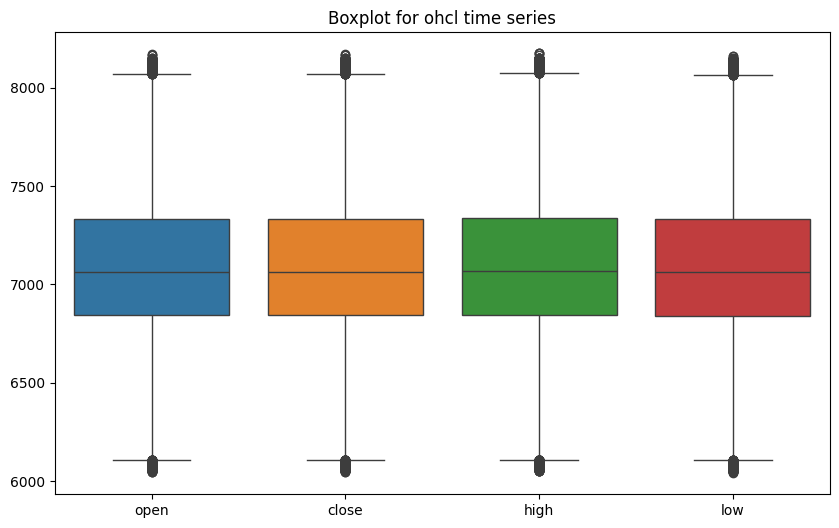

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['open', 'close', 'high', 'low']])
plt.title(f'Boxplot for ohcl time series')
plt.show()

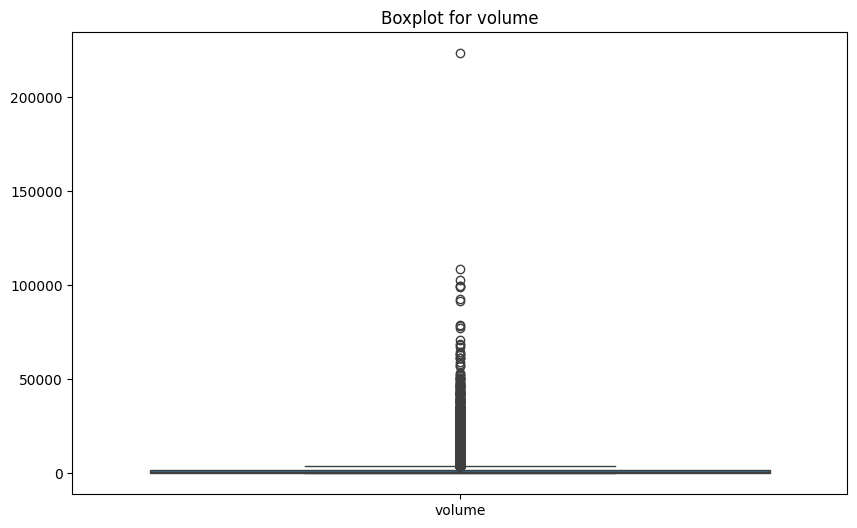

In [ ]:
plt.figure(figsize=(10, 6))
sns.boxplot(data=df[['volume']])
plt.title(f'Boxplot for volume')
plt.show()

In [ ]:
def plot_stats(df_ohlcv: pd.DataFrame, name):
  df['log_return'] = df_ohlcv
  plt.figure(figsize=(10, 6))
  sns.histplot(df['log_return'].dropna())
  plt.title(f'Log Returns Distribution for {name}')
  plt.ylim(0, 1000)
  plt.show()

  # Check for normal distribution
  stat, p_value = shapiro(df['log_return'].dropna())
  print(f'Shapiro-Wilk Test: Statistics={stat}, p-value={p_value}')

  stat, p_value = kstest(df['log_return'].dropna(), 'norm')
  print(f'Kolmogorov-Smirnov Test: Statistics={stat}, p-value={p_value}')

  # Stationarity of the series
  result = adfuller(df['log_return'].dropna())
  print(f'ADF Test: Statistics={result[0]}, p-value={result[1]}')


  plt.figure(figsize=(20, 10))

  plot_acf(df['log_return'].dropna(), lags=521, alpha=0.05)
  plt.title(f'ACF for {name}')
  plt.ylim(0, 0.3)

  ax = plt.gca()

  plt.xticks(
      ticks=np.arange(0, 521, 40),
      rotation=25,
      ha='right',
  )

  ax.grid(True, which='both', linestyle='--', linewidth=0.5)

  plt.show()

  plot_pacf(df['log_return'].dropna(), lags=600)
  plt.title(f'PACF for {name}')
  plt.ylim(0, 0.04)
  plt.show()

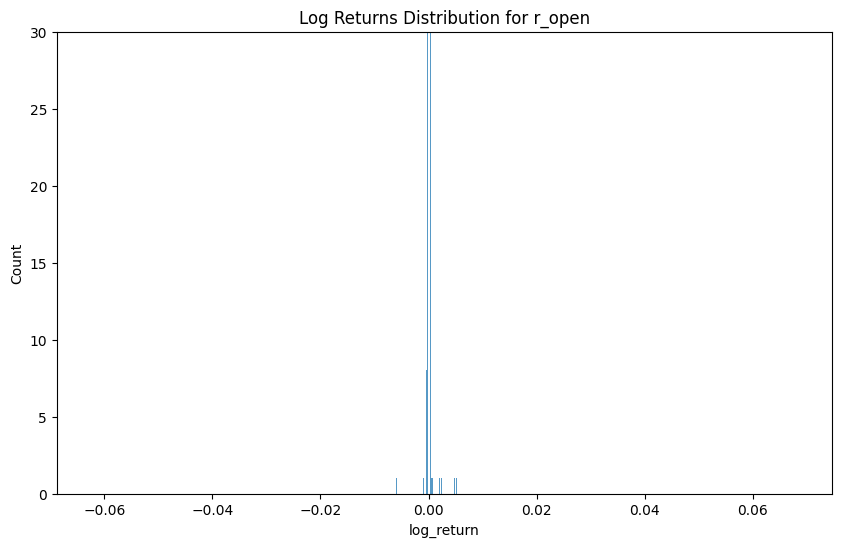

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 131090.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistics=0.09452261837098475, p-value=1.152639035103027e-188
Kolmogorov-Smirnov Test: Statistics=0.4989228665052501, p-value=0.0
ADF Test: Statistics=-362.42380736678416, p-value=0.0


<Figure size 2000x1000 with 0 Axes>

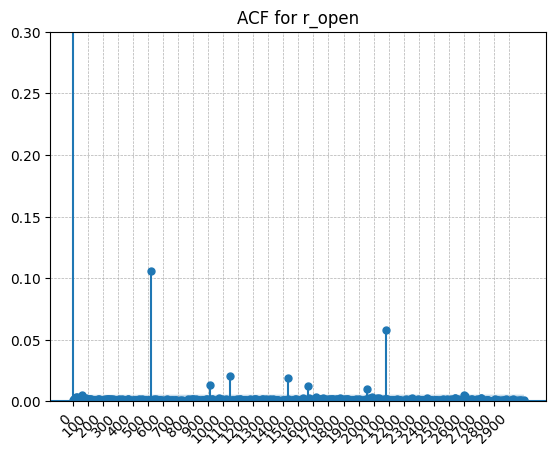

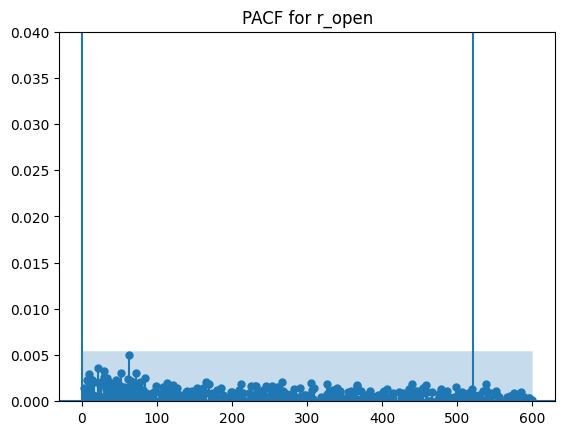

In [ ]:
# For r_open
df_ohlcv = np.log(df['open'] / df['close'].shift(1))
plot_stats(df_ohlcv, "r_open")

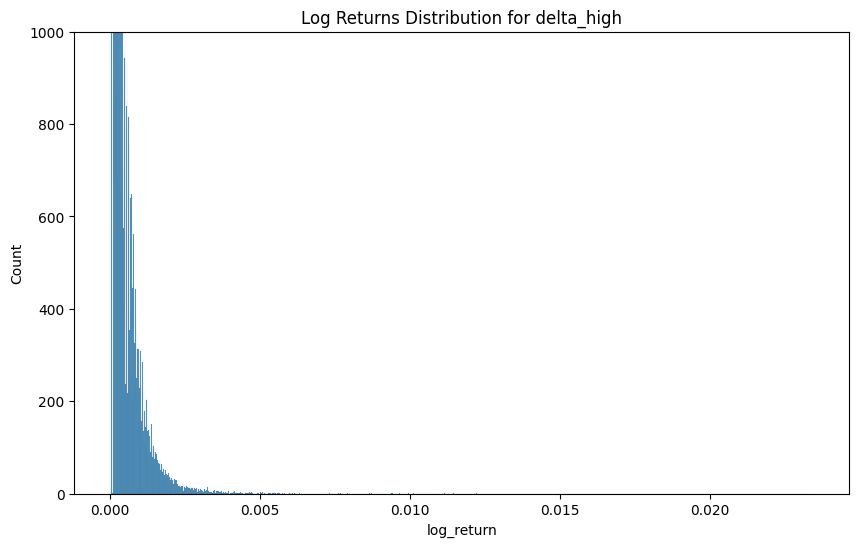

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 131091.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistics=0.6053982274739271, p-value=3.999681788858954e-160
Kolmogorov-Smirnov Test: Statistics=0.5, p-value=0.0
ADF Test: Statistics=-25.09301287155706, p-value=0.0


<Figure size 2000x1000 with 0 Axes>

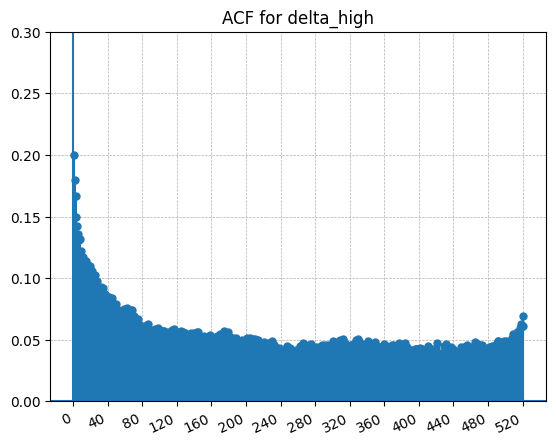

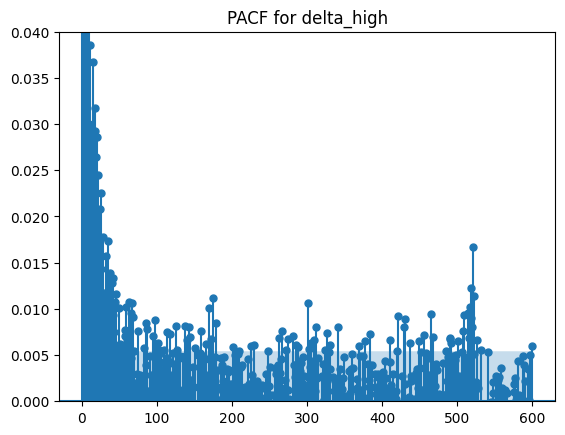

In [ ]:
# For delta_high
df_ohlcv = np.log(df['high'] / df['open'])
plot_stats(df_ohlcv, "delta_high")

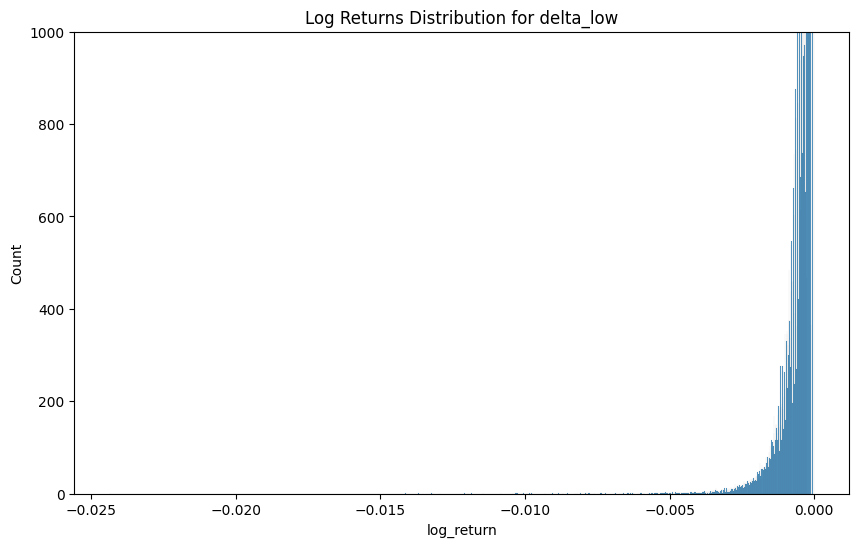

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 131091.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistics=0.597670305493496, p-value=9.173905915973399e-161
Kolmogorov-Smirnov Test: Statistics=0.5, p-value=0.0
ADF Test: Statistics=-23.840405707554368, p-value=0.0


<Figure size 2000x1000 with 0 Axes>

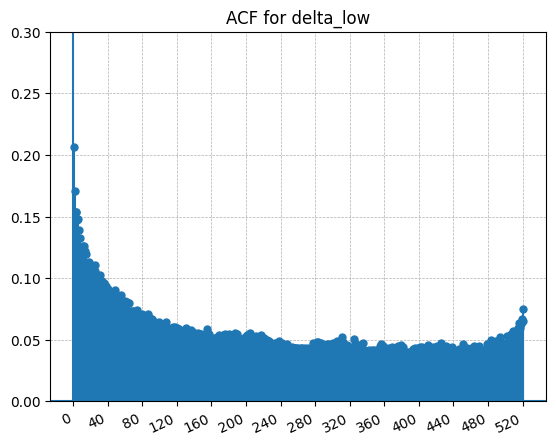

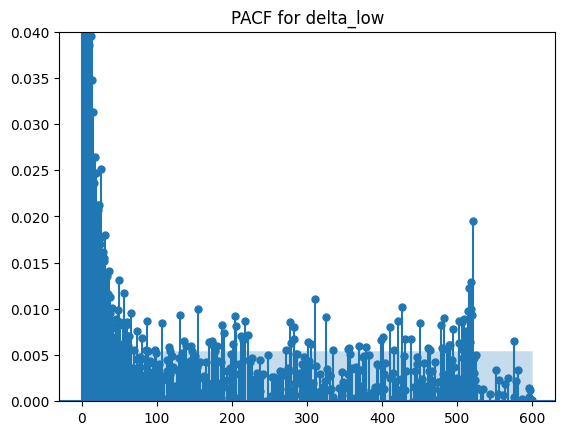

In [ ]:
# For delta_low
df_ohlcv = np.log(df['low'] / df['open'])
plot_stats(df_ohlcv, "delta_low")

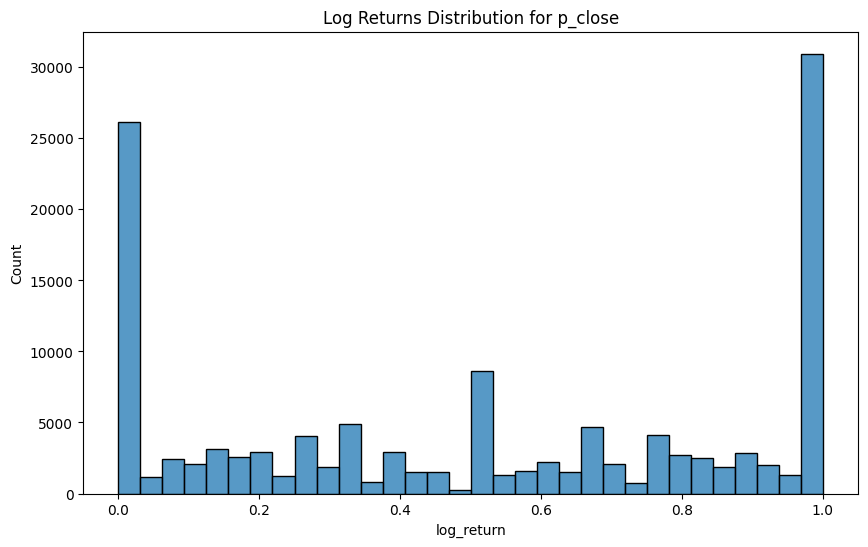

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 130636.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistics=0.8696413418521293, p-value=1.1426961383316113e-125
Kolmogorov-Smirnov Test: Statistics=0.5, p-value=0.0
ADF Test: Statistics=-28.029614596245196, p-value=0.0


<Figure size 2000x1000 with 0 Axes>

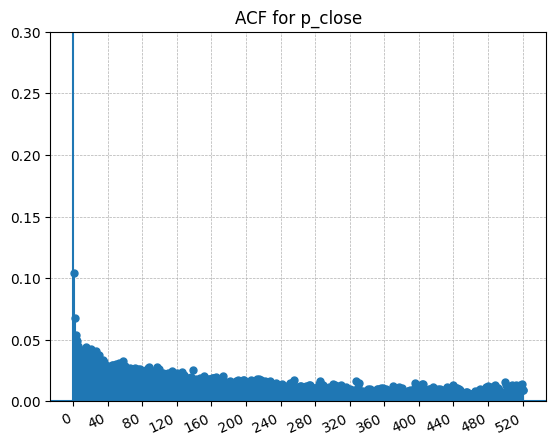

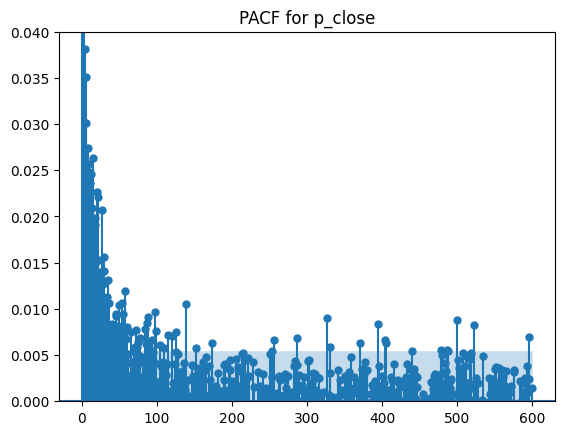

In [ ]:
# For p_close
log_high = np.log(df['high'])
log_low = np.log(df['low'])
df_ohlcv = (np.log(df['close']) - log_low) / (log_high - log_low)
plot_stats(df_ohlcv, "p_close")

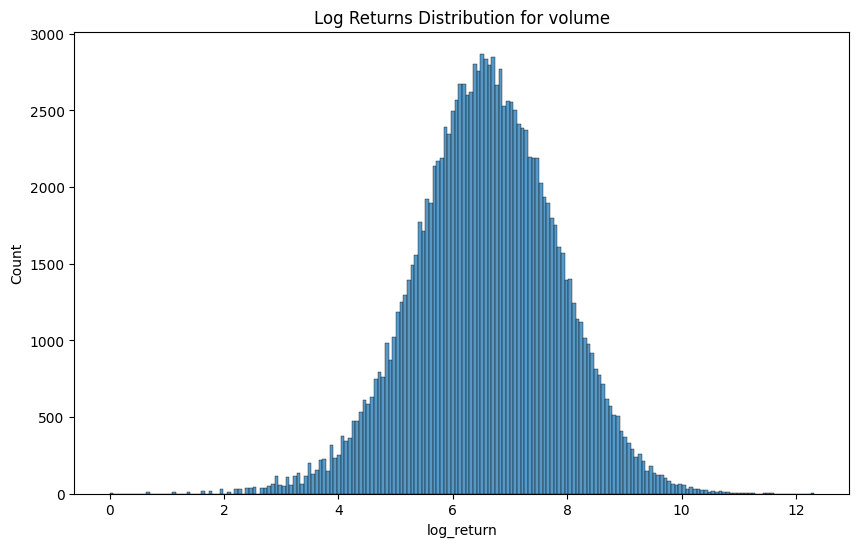

/usr/local/lib/python3.11/dist-packages/scipy/stats/_axis_nan_policy.py:573: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 131091.
  res = hypotest_fun_out(*samples, **kwds)


Shapiro-Wilk Test: Statistics=0.9981932697422244, p-value=2.1218010293094438e-32
Kolmogorov-Smirnov Test: Statistics=0.9944996160862821, p-value=0.0
ADF Test: Statistics=-20.894455936111974, p-value=0.0


<Figure size 2000x1000 with 0 Axes>

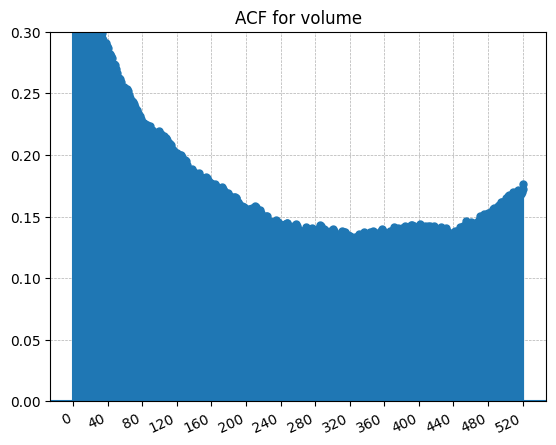

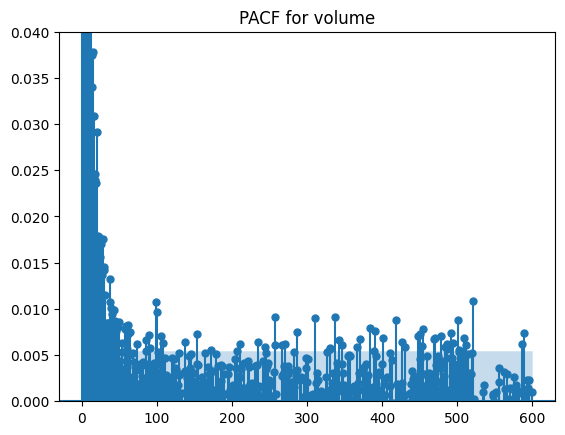

In [ ]:
# For volume
df_ohlcv = np.log(df['volume'] + 1e-8)
plot_stats(df_ohlcv, "volume")

<ipython-input-154-9d19a7a8d7ec>:10: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


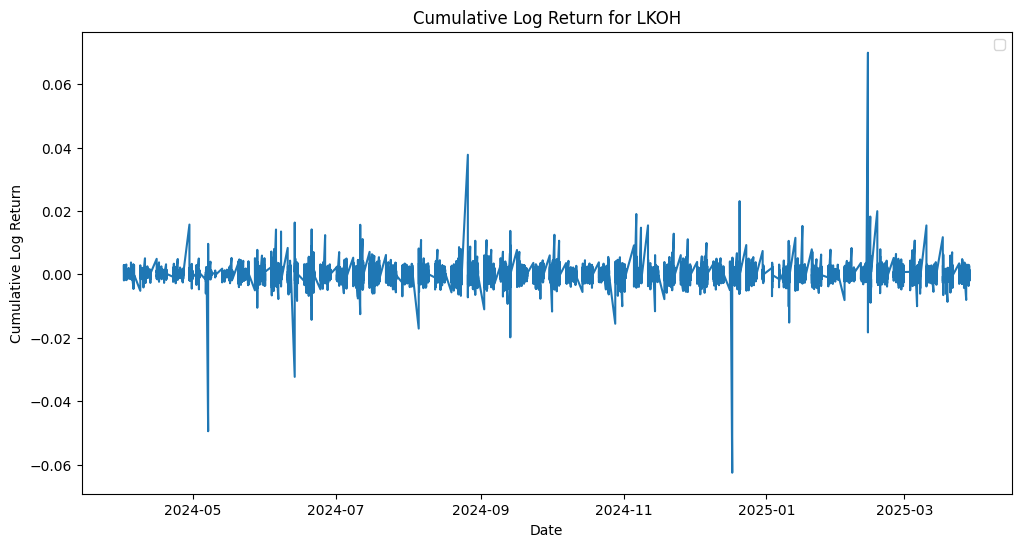

In [ ]:
df['log_return'] = np.log(df['close'] / df['open'].shift(1))

plt.figure(figsize=(12, 6))

plt.plot(df['log_return'])

plt.xlabel('Date')
plt.ylabel('Cumulative Log Return')
plt.title('Cumulative Log Return for LKOH')
plt.legend()
plt.show()

<ipython-input-148-29628b805288>:8: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


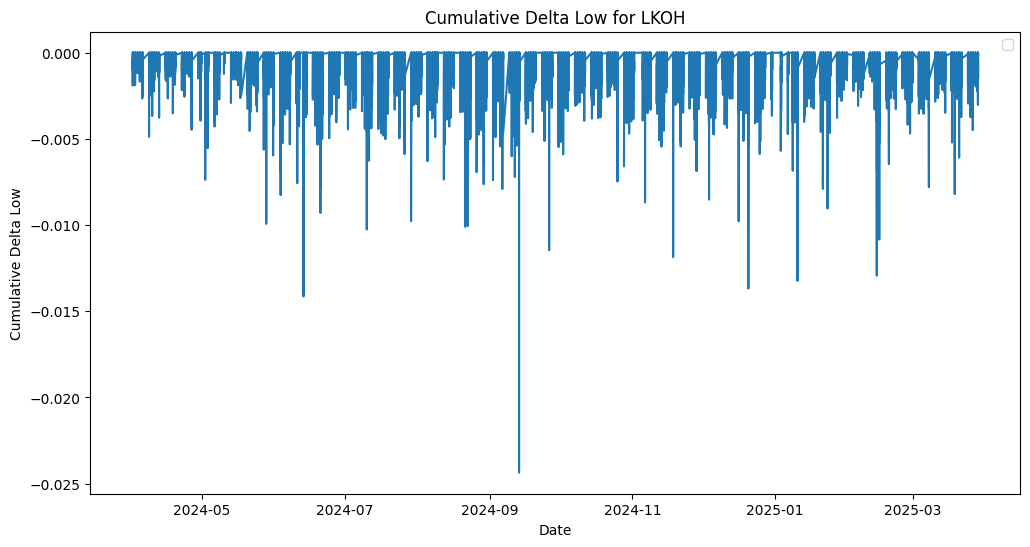

In [ ]:
plt.figure(figsize=(12, 6))

plt.plot(np.log(df['low'] / df['open']).dropna())

plt.xlabel('Date')
plt.ylabel('Cumulative Delta Low')
plt.title('Cumulative Delta Low for LKOH')
plt.legend()
plt.show()

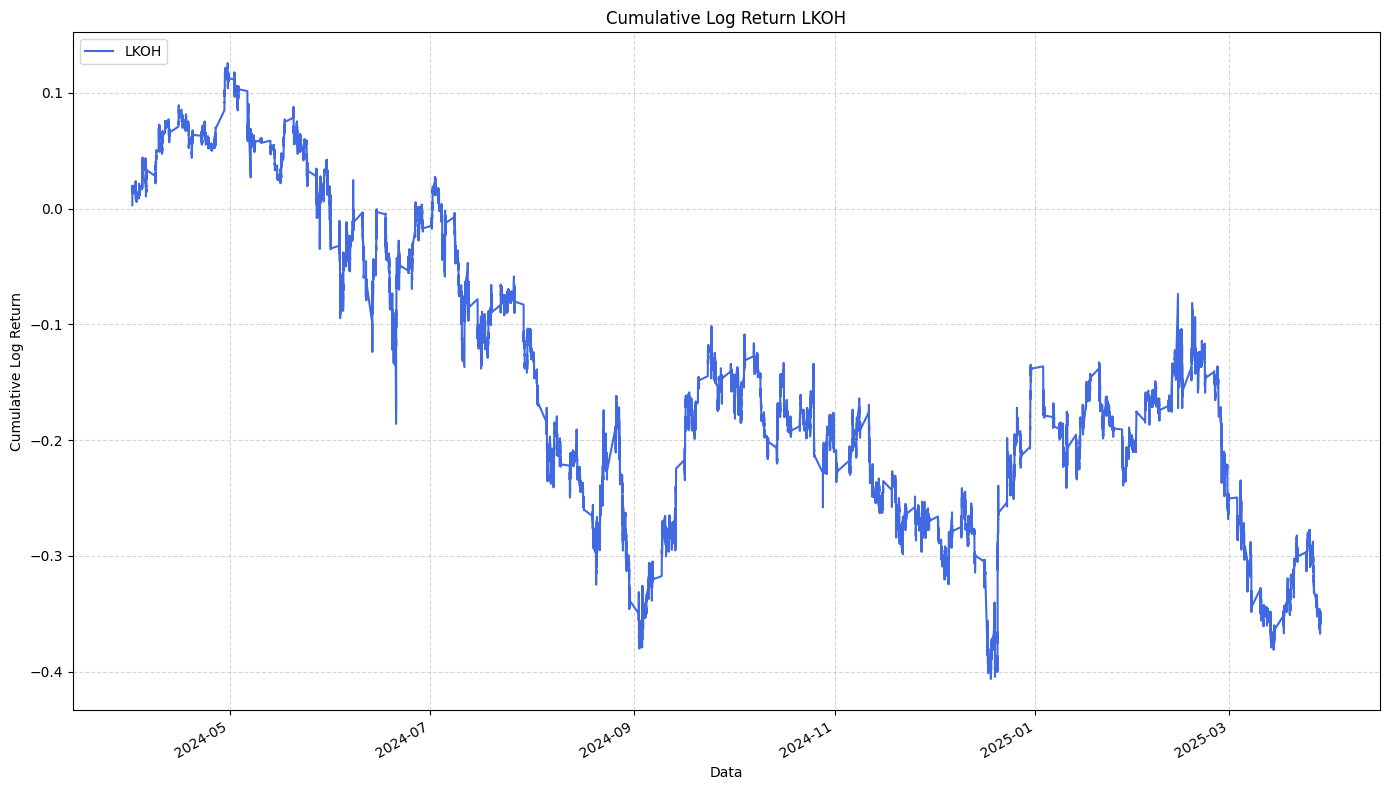

In [ ]:
df["cumulative_log_return"] = (np.log(df['close'] / df['open'].shift(1))).cumsum()

plt.figure(figsize=(14, 8))
plt.plot(df.index,
         df["cumulative_log_return"],
         color='royalblue',
         linewidth=1.5,
         label='LKOH')

plt.xlabel("Data")
plt.ylabel("Cumulative Log Return")
plt.title("Cumulative Log Return LKOH")
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend(loc="upper left", frameon=True)

plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()